In [139]:
import os 
import re
import time
import random
import numpy as np
import pandas as pd 
import networkx as nx
from copy import deepcopy
from threading import Thread
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation

verbose = False
find_optimal = False
all_jobs = False
fine_tune = False

In [140]:
class CPU:
    def __init__(self, number_of_cores=0, clock_rate_in_hz=0.0, family_name='', denomination=''):
        """
        Initializes a new CPU with the given parameters.
        """
        self.number_of_cores = number_of_cores
        self.clock_rate_in_hz = clock_rate_in_hz
        self.family_name = family_name
        self.denomination = denomination

    def duplicate(self):
        """
        Creates and returns a deep copy of this CPU.
        """
        return deepcopy(self)

    def outperforms(self, cpu_to_compare_with, multithreaded_program_execution):
        """
        Returns True if this CPU outperforms the one passed in as a parameter for the specified type of program.
        """

        # Priority mapping for CPU families and denominations
        cpu_hierarchy = {
            'core i9': 4,
            'core i7': 3,
            'core i5': 2,
            'core i3': 1
        }

        # Determine the CPU type
        this_cpu_type = f"{self.family_name} {self.denomination}".lower()
        other_cpu_type = f"{cpu_to_compare_with.family_name} {cpu_to_compare_with.denomination}".lower()

        # Compare based on family/denomination hierarchy
        this_priority = cpu_hierarchy.get(this_cpu_type, 0)
        other_priority = cpu_hierarchy.get(other_cpu_type, 0)

        if this_priority != other_priority:
            return this_priority > other_priority

        # If the same family, compare based on multithread or single-thread performance
        if multithreaded_program_execution:
            return self.number_of_cores > cpu_to_compare_with.number_of_cores
        else:
            return self.clock_rate_in_hz > cpu_to_compare_with.clock_rate_in_hz

    def __eq__(self, other):
        """
        Compares if two CPU objects are equivalent in terms of performance.
        This allows using '==' for CPU objects.
        """
        if not isinstance(other, CPU):
            return NotImplemented
        return (self.family_name == other.family_name and
                self.denomination == other.denomination and
                self.number_of_cores == other.number_of_cores and
                self.clock_rate_in_hz == other.clock_rate_in_hz)


In [141]:
class Worker:
    def __init__(self, ID=0, cpu_info=None, current_global_cpu_time=0.0, available_memory_size=0.0, 
                 available_disk_size=0.0, assigned_jobs=None, connection_bandwidth_with_master_pc=0.0, 
                 connection_delay_with_master_pc=0.0, cpu_usage_in_percentage=0.0, name="", 
                 original_available_memory_size=0.0, original_available_disk_size=0.0, 
                 original_connection_bandwidth_with_master_pc=0.0, original_connection_delay_with_master_pc=0.0):
        self.ID = ID
        self.cpu_info = cpu_info
        self.available_memory_size = available_memory_size
        self.available_disk_size = available_disk_size
        self.connection_bandwidth_with_master_pc = connection_bandwidth_with_master_pc
        self.connection_delay_with_master_pc = connection_delay_with_master_pc
        self.original_available_memory_size = original_available_memory_size
        self.original_available_disk_size = original_available_disk_size
        self.original_connection_bandwidth_with_master_pc = original_connection_bandwidth_with_master_pc
        self.original_connection_delay_with_master_pc = original_connection_delay_with_master_pc
        self.assigned_jobs = assigned_jobs if assigned_jobs is not None else []
        self.cpu_usage_in_percentage = cpu_usage_in_percentage
        self.name = name
        self.current_global_cpu_time = current_global_cpu_time
        self.base10_name = 0
    def duplicate(self):
        return deepcopy(self)

    def print(self):
        print("********** Worker PC Details **********")
        print(f"ID: {self.ID}")
        print(f"Name: {self.name}")
        print(f"Current Global CPU Time: {self.current_global_cpu_time}")
        print(f"CPU Number Of Cores: {self.cpu_info.number_of_cores}")
        print(f"CPU Clock Rate In GHz: {self.cpu_info.clock_rate_in_hz / 1_000_000_000}")
        print(f"CPU Name: {self.cpu_info.family_name} {self.cpu_info.denomination}")
        print(f"Available Memory Size: {self.available_memory_size}")
        print(f"Available Disk Size: {self.available_disk_size}")
        print(f"Connection Bandwidth With Master PC: {self.connection_bandwidth_with_master_pc}")
        print(f"Connection Delay With Master PC: {self.connection_delay_with_master_pc}")
        print(f"CPU Usage In Percentage: {self.cpu_usage_in_percentage}")
        print("----- Assigned Jobs -----")
        for job in self.assigned_jobs:
            print(f"Job Name: {job.name}")
        print("********** End **********\n\n")

    def can_handle_job(self, job):
        if self.available_memory_size < job.required_memory_size_for_execution:
            return False
        if self.available_disk_size < job.required_disk_size_for_execution:
            return False
        if self.cpu_info.number_of_cores < job.thread_process_count:
            return False
        return True

    def reset_resource_usage(self, job):
        self.cpu_usage_in_percentage = 0.0
        self.available_disk_size += job.required_disk_size_for_execution
        self.available_memory_size += job.required_memory_size_for_execution

    def execute_job(self, job):
        job_execution_thread = Thread(target=job.run)
        job_execution_thread.start()


In [142]:
class Job(Thread):  # Inherit from threading.Thread to make the class runnable
    def __init__(self, ID=0, standard_processing_durations=None, required_memory_size_for_execution=0.0, 
                 required_disk_size_for_execution=0.0, assigned_worker=None, job_current_cpu_time=0.0, 
                 docker_file_size=0.0, assignment_time=0, estimated_result_file_size=0.0, 
                 docker_file_generation_duration_on_master_pc=0.0, currently_being_processed_on_assigned_worker=False, 
                 thread_process_count=1, currently_assigned_to_worker=False, 
                 finished_being_processed_on_assigned_worker=False, name="", induced_cpu_usage_increase_percentage=0.0):
        super().__init__()
        self.ID = ID
        self.standard_processing_durations = standard_processing_durations or {}
        self.required_memory_size_for_execution = required_memory_size_for_execution
        self.required_disk_size_for_execution = required_disk_size_for_execution
        self.assigned_worker = assigned_worker
        self.job_current_cpu_time = job_current_cpu_time
        self.docker_file_size = docker_file_size
        self.assignment_time = assignment_time
        self.estimated_result_file_size = estimated_result_file_size
        self.docker_file_generation_duration_on_master_pc = docker_file_generation_duration_on_master_pc
        self.currently_being_processed_on_assigned_worker = currently_being_processed_on_assigned_worker
        self.thread_process_count = thread_process_count
        self.currently_assigned_to_worker = currently_assigned_to_worker
        self.finished_being_processed_on_assigned_worker = finished_being_processed_on_assigned_worker
        self.name = name
        self.induced_cpu_usage_increase_percentage = induced_cpu_usage_increase_percentage

    def duplicate(self, job):
        return deepcopy(self)

    def run(self):
        try:
            self.currently_being_processed_on_assigned_worker = True
            if self.assigned_worker:
                print(f"{self.assigned_worker.name}---<< {self.name} <<---")

                # Simulating processing time based on the assigned worker's CPU info
                family_name = self.assigned_worker.cpu_info['family_name']
                denomination = self.assigned_worker.cpu_info['denomination']
                cores = self.assigned_worker.cpu_info['number_of_cores']
                key = f"{family_name}-{denomination}-{cores}"

                # Sleep for the standard processing duration
                if key in self.standard_processing_durations:
                    processing_time = self.standard_processing_durations[key]
                    time.sleep(processing_time)

                # Processing complete
                self.finished_being_processed_on_assigned_worker = True
                self.currently_being_processed_on_assigned_worker = False
                print(f"{self.assigned_worker.name}--->> {self.name} >>---")

                # Update worker's resources after processing
                self.assigned_worker.assigned_jobs.remove(self)
                self.assigned_worker.available_disk_size += self.required_disk_size_for_execution
                self.assigned_worker.available_memory_size += self.required_memory_size_for_execution
                self.assigned_worker.cpu_usage_in_percentage -= self.induced_cpu_usage_increase_percentage

                # Reset job's worker assignment
                self.currently_assigned_to_worker = False
                self.assigned_worker = None

        except Exception as e:
            print(f"Job execution failed: {e}")

    def print(self):
        print("++++++++++ Job Details ++++++++++")
        print(f"ID: {self.ID}")
        print(f"Name: {self.name}")
        for cpu, duration in self.standard_processing_durations.items():
            print(f"Standard Processing Duration On {cpu}: {duration}")
        print(f"Required Memory Size For Execution: {self.required_memory_size_for_execution}")
        print(f"Required Disk Size For Execution: {self.required_disk_size_for_execution}")
        print(f"Docker File Size: {self.docker_file_size}")
        print(f"Arrival Time: {self.assignment_time}")
        print(f"Thread Process Count: {self.thread_process_count}")
        print(f"Estimated Result File Size: {self.estimated_result_file_size}")
        print(f"Docker File Generation Duration On Master PC: {self.docker_file_generation_duration_on_master_pc}")
        print(f"Current CPU Time: {self.job_current_cpu_time}")
        print(f"Currently Assigned To Worker: {self.currently_assigned_to_worker}")
        print(f"Currently Being Processed On Assigned Worker: {self.currently_being_processed_on_assigned_worker}")
        print(f"Finished Being Processed On Assigned Worker: {self.finished_being_processed_on_assigned_worker}")
        if self.assigned_worker:
            print(f"Assigned Worker: {self.assigned_worker.name}")
        print("++++++++++ End ++++++++++\n\n")


In [143]:
class Match:
    def __init__(self, value, pheromone):
        self.value = value  # value is expected to be a tuple (job, worker)
        self.pheromone = pheromone
        self.processing_duration = self.calculate_processing_duration()

    def calculate_processing_duration(self):
        job, worker = self.value
        # Use the worker's name (e.g., 'PC1') to get the correct duration from the job's dictionary
        return job.standard_processing_durations[worker.name]  # Assume worker has an 'name' or identifier like 'PC1'


In [144]:
class Ant:
    def __init__(self, id, path=[]):
        self.id = id
        self.path = path

In [145]:
def generate_paths(ants, jobs, matches, alpha, beta):
    for ant in ants:
        ant.path = []
        for job in jobs:
            matching_elements = [match for match in matches if match.value[0] == job]
            p = calculate_probabilities(matching_elements, alpha, beta)  # calculate probabilities (worker, probability)
            r = random.random()
            w = pick_worker(r, p)
            ant.path.append((job, w))  # append job-worker pair to the ant's path
    return ants

def calculate_probabilities(matches, alpha, beta):
    """
    Calculate the probability of selecting each worker for the given job.
    
    :param matches: List of Match objects where value[0] is the job and value[1] is the worker.
    :param alpha: Weight for pheromone importance.
    :param beta: Weight for processing duration (distance) importance.
    :return: List of tuples (worker, probability).
    """
    desirabilities = []
    total_desirability = 0

    # Calculate desirability for each match and sum them for normalization
    for match in matches:
        worker = match.value[1]  # worker is the second item in the tuple (job, worker)
        pheromone = match.pheromone
        processing_duration = match.processing_duration
        proximity = 1 / processing_duration  # Inverse of the distance is the proximity

        # Desirability formula: τ_ik^α * η_ik^β
        desirability = (pheromone ** alpha) * (proximity ** beta)
        desirabilities.append((worker, desirability))
        total_desirability += desirability

    # Normalize desirabilities to get probabilities
    probabilities = [(worker, desirability / total_desirability) for worker, desirability in desirabilities]

    return probabilities

def pick_worker(random_value, worker_probabilities):
    """
    Select a worker based on the calculated probabilities and a random value.
    
    :param random_value: Random number between 0 and 1.
    :param worker_probabilities: List of tuples (worker, probability).
    :return: The selected worker.
    """
    cumulative_prob = 0

    for worker, probability in worker_probabilities:
        cumulative_prob += probability
        if random_value <= cumulative_prob:
            return worker  # Return the exact worker when the random value falls within the cumulative probability

    return worker_probabilities[-1][0]  # Fallback to return the last worker in case of rounding issues


In [146]:
def pheromone_update(ants, matches, evap_coeff, Q):
    """
    Updates the pheromone levels on the matches based on the ants' paths.

    :param ants: List of ants, where each ant has a path attribute (a list of job-worker tuples).
    :param matches: List of Match objects with pheromone levels to be updated.
    :param evap_coeff: Coefficient for pheromone evaporation (ρ).
    :param Q: Constant value for pheromone deposition.
    :return: Updated matches with new pheromone levels.
    """
    # Evaporate pheromones on all matches
    for match in matches:
        match.pheromone *= evap_coeff  # Apply evaporation to all pheromone values

    # Update pheromones based on each ant's path
    for ant in ants:
        l = max_worker_processing_duration(ant.path)  # Max processing duration across workers
        pheromone = Q / l      # Calculate pheromone to deposit (Δτ_ij)

        for match in matches:
            if match.value in ant.path:  # Check if the job-worker pair was part of the ant's path
                match.pheromone += pheromone  # Add pheromone based on the ant's contribution

    return matches

def max_worker_processing_duration(path):
    """
    Calculates the maximum processing duration for any worker in the ant's path, 
    considering the worker's ability to run jobs simultaneously based on resource availability.
    
    :param path: A list of tuples (job, worker) representing the path of an ant.
    :return: The maximum processing duration across all workers.
    """
    # Dictionary to store jobs per worker, using worker.name as the key
    worker_jobs = {}

    # Group jobs by worker
    for job, worker in path:
        if worker.name not in worker_jobs:
            worker_jobs[worker.name] = {'worker': worker, 'jobs': []}  # Store worker object alongside jobs
        worker_jobs[worker.name]['jobs'].append(job)

    max_duration = 0

    # Evaluate the total processing duration per worker
    for worker_info in worker_jobs.values():
        worker = worker_info['worker']  # Get the worker object
        jobs = worker_info['jobs']  # Get the list of jobs
        worker_duration = calculate_worker_duration(jobs, worker)
        max_duration = max(max_duration, worker_duration)

    return max_duration

def calculate_worker_duration(jobs, worker):
    """
    Calculates the total duration for a worker considering simultaneous job execution
    based on the worker's available resources (memory, disk, CPU cores).
    
    :param jobs: List of jobs assigned to the worker.
    :param worker: The worker object with available resources (memory, disk, cores).
    :return: The total time required for the worker to complete all jobs.
    """
    # Sort jobs by their processing duration as a heuristic to allocate resources efficiently
    jobs = sorted(jobs, key=lambda job: job.standard_processing_durations[worker.name])

    total_time = 0
    # Initialize available resources for the worker
    available_memory = worker.available_memory_size
    available_disk = worker.available_disk_size
    available_cores = worker.cpu_info.number_of_cores

    # List of jobs that are executing in parallel with their remaining durations
    executing_jobs = []

    # List to track remaining job processing times
    remaining_durations = {job: job.standard_processing_durations[worker.name] for job in jobs}

    while jobs or executing_jobs:
        # Try to allocate more jobs to be executed in parallel
        remaining_jobs = []
        for job in jobs:
            # Check if the worker can handle this job along with the currently executing jobs
            if (available_memory >= job.required_memory_size_for_execution and
                available_disk >= job.required_disk_size_for_execution and
                available_cores >= job.thread_process_count):
                
                # If the worker can handle this job, add it to the executing jobs
                executing_jobs.append(job)
                available_memory -= job.required_memory_size_for_execution
                available_disk -= job.required_disk_size_for_execution
                available_cores -= job.thread_process_count
            else:
                # If the worker can't handle it, put it back in the remaining jobs
                remaining_jobs.append(job)

        # If no jobs are currently executing, we advance time by the duration of the job that finishes next
        if executing_jobs:
            # Find the job with the shortest remaining processing time in the current executing jobs
            min_duration = min(remaining_durations[job] for job in executing_jobs)
            total_time += min_duration

            # Remove completed jobs and update available resources
            completed_jobs = []
            for job in executing_jobs:
                remaining_durations[job] -= min_duration  # Reduce the remaining duration for this job
                if remaining_durations[job] == 0:  # Job has finished
                    available_memory += job.required_memory_size_for_execution
                    available_disk += job.required_disk_size_for_execution
                    available_cores += job.thread_process_count
                    completed_jobs.append(job)

            # Remove completed jobs from the executing list
            executing_jobs = [job for job in executing_jobs if job not in completed_jobs]

        # Update the jobs list with the remaining jobs for the next iteration
        jobs = remaining_jobs

    return total_time

In [147]:
def visualize_network(jobs, workers, matches, ax):
    """
    Visualizes the job-worker bipartite graph with NetworkX, where edge thickness represents pheromone levels.
    
    :param jobs: List of job objects.
    :param workers: List of worker objects.
    :param matches: List of Match objects with pheromone levels.
    :param iteration: The current iteration number (optional, for labeling the plot).
    """
    G = nx.DiGraph()
    
    # Create nodes for jobs and workers
    job_nodes = [f"{job.name}_{i}" for i, job in enumerate(jobs)]
    worker_nodes = [worker.name for worker in workers]
    
    # Add job and worker nodes to the graph
    G.add_nodes_from(job_nodes, bipartite=0, color='blue')
    G.add_nodes_from(worker_nodes, bipartite=1, color='green')
    
    # Add edges with pheromone as weight
    # edge_labels = {}
    for match in matches:
        job, worker = match.value
        job_name = f"{job.name}_{jobs.index(job)}"
        pheromone = match.pheromone
        edge_weight = match.processing_duration
        edge_thickness = 150*pheromone  

        # Edge from job to worker
        G.add_edge(job_name, worker.name, weight=edge_weight, thickness=edge_thickness)
        # # Prepare labels for edges: (pheromone, processing duration)
        # edge_labels[(job_name, worker.name)] =f"{pheromone:.2f} ; {edge_weight}"
    
    # Define positions with spacing
    vertical_offset = 10
    max_y = (len(job_nodes)*vertical_offset)
    pos = {}
    pos.update((job, (0, i * vertical_offset)) for i, job in enumerate(job_nodes))  # Jobs on left
    pos.update((worker, (1, i + i * max_y/len(workers))) for i, worker in enumerate(worker_nodes))  # Workers on right

    # Adjust edge label positions (move toward the left)
    # edge_label_pos = {
    #     (u, v): (
    #         0.75 * pos[u][0] + 0.25 * pos[v][0],
    #         0.75 * pos[u][1] + 0.25 * pos[v][1],
    #     )
    #     for u, v in G.edges()
    #     if u in pos and v in pos  # Ensure both nodes exist in pos
    # }


    # Draw nodes
    job_colors = 'skyblue'
    worker_colors = 'lightgreen'
    nx.draw_networkx_nodes(G, pos, nodelist=job_nodes, node_color=job_colors, node_size=300, label="Jobs", ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=worker_nodes, node_color=worker_colors, node_size=300, label="Workers", ax=ax)
    
    # Draw edges with width based on pheromone level
    edges = G.edges(data=True)
    edge_widths = [data['thickness'] for _, _, data in edges]
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths, alpha=0.5, edge_color="gray")
    
    # Draw labels for nodes
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black", ax=ax)
    
    # Draw edge labels (pheromone level and processing duration)
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color="red", ax=ax)

In [148]:
def evaluate(jobs, matches):
    """
    Evaluates the matches to determine the optimal path with the minimum processing duration.
    
    :param jobs: List of jobs.
    :param matches: List of Match objects (job-worker pairs with pheromone and processing duration).
    :return: A tuple containing the optimal path and the total processing duration.
             The optimal path is a list of tuples (job, worker), and the total duration is an integer.
    """
    optimal_path = []
    worker_jobs = {}  # Dictionary to store jobs assigned to each worker

    # Build the optimal path by selecting the match with the highest pheromone level for each job
    for job in jobs:
        # Filter matches that correspond to the current job
        job_matches = [match for match in matches if match.value[0] == job]

        # Select the match with the highest pheromone level (most likely assignment)
        best_match = max(job_matches, key=lambda m: m.pheromone)

        # Add the job-worker pair to the optimal path
        worker = best_match.value[1]
        optimal_path.append((job, worker))

        # Store the job under the worker's list of jobs
        if worker not in worker_jobs:
            worker_jobs[worker] = []
        worker_jobs[worker].append(job)

    # Calculate the total processing duration based on the max worker processing duration
    total_processing_duration = 0
    for worker, assigned_jobs in worker_jobs.items():
        worker_duration = calculate_worker_duration(assigned_jobs, worker)
        total_processing_duration = max(total_processing_duration, worker_duration)

    return optimal_path, total_processing_duration
    
def format_duration(seconds):
    """
    Converts a duration from seconds to a string in the format of hours, minutes, and seconds.
    
    :param seconds: The total duration in seconds.
    :return: A string representing the duration in 'H hours M minutes S seconds' format.
    """
    hours, remainder = divmod(seconds, 3600)  # Get hours and the remainder seconds
    minutes, seconds = divmod(remainder, 60)  # Get minutes and remaining seconds

    # Build the formatted string
    duration_str = f"{int(hours)} hours {int(minutes)} minutes {int(seconds)} seconds"
    
    return duration_str


In [149]:
def ACO(jobs, workers, matches, ants, alpha, beta, evap_coeff, Q, max_iterations=100, tolerance=1e-5, patience=20, verbose=0, animate=0):
    """
    Runs the Ant Colony Optimization (ACO) algorithm to find the optimal job-worker assignments.
    
    :param jobs: List of jobs.
    :param matches: List of Match objects (job-worker pairs with pheromone and processing duration).
    :param ants: List of Ant objects, where each ant has a path.
    :param alpha: Pheromone influence factor.
    :param beta: Heuristic information influence factor.
    :param evap_coeff: Coefficient for pheromone evaporation (ρ).
    :param Q: Constant value for pheromone deposition.
    :param max_iterations: Maximum number of iterations to run.
    :param tolerance: Threshold to stop the algorithm when the change in total duration is small enough.
    :param patience: Number of consecutive iterations without significant improvement before stopping.
    :return: A tuple containing the optimal path and the total processing duration.
    """
    previous_duration = float('inf')  # Start with an infinitely large duration
    iteration = 0
    no_improvement_count = 0  # Counter for iterations without significant improvement
    if animate:
        fig, ax = plt.subplots(figsize=(12, 8))
        frames = []

        # Directory to store frames temporarily
        temp_dir = "./frames"
        os.makedirs(temp_dir, exist_ok=True)

    while iteration < max_iterations:
        if animate:
            # Clear axis to prevent overlap
            ax.clear()
        
        # Generate paths for ants based on current pheromone levels
        ants = generate_paths(ants, jobs, matches, alpha, beta)

        # Update pheromone levels based on the paths taken by the ants
        matches = pheromone_update(ants, matches, evap_coeff, Q)

        if animate:
            # Capture frame
            visualize_network(jobs, workers, matches, ax)
            ax.set_title(f"Iteration {iteration}")
    
            # Save the current figure as an image file and store the filename
            filename = os.path.join(temp_dir, f"frame_{iteration}.png")
            plt.savefig(filename, dpi= 300)
            frames.append(filename)

        # Evaluate the current best path and its total duration
        optimal_path, total_duration = evaluate(jobs, matches)

        # Calculate the difference in total duration between iterations
        duration_difference = abs(previous_duration - total_duration)

        # Check if the difference is below the tolerance (convergence criteria)
        if duration_difference < tolerance:
            no_improvement_count += 1
        else:
            no_improvement_count = 0  # Reset the count if there's significant improvement

        # If there has been no significant improvement for a certain number of iterations, break
        if no_improvement_count >= patience:
            if verbose:
                print(f"No significant improvement for {patience} consecutive iterations. Stopping.")
                print(f"Converged at iteration {iteration} with duration difference {duration_difference}")
            break

        # Update previous duration and increment iteration counter
        previous_duration = total_duration
        iteration += 1

    if animate:
        # Compile images into an animation
        images = [plt.imread(frame) for frame in frames]
        ani = animation.ArtistAnimation(fig, [[plt.imshow(img, animated=True)] for img in images], interval=500, blit=True)
        ani.save("ACO_animation.gif", writer="pillow", fps=2)
    
        # Clean up temporary frame files
        for frame in frames:
            os.remove(frame)
        os.rmdir(temp_dir)

    plt.show()
    
    # Return the best path found and its total processing duration
    print(total_duration)
    return optimal_path, total_duration


In [150]:
jobData = pd.read_csv("data/jobs18.csv")
workersData = pd.read_csv("data/workers.csv")

In [151]:
def create_jobs_from_df(df):
    jobs = []
    
    for index, row in df.iterrows():
        # Parse the processing durations for each PC
        standard_processing_durations = {
            'PC1': parse_time_to_seconds(row['Standard Processing Duration PC1']),
            'PC2': parse_time_to_seconds(row['Standard Processing Duration PC2']),
            'PC3': parse_time_to_seconds(row['Standard Processing Duration PC3']),
            'PC4': parse_time_to_seconds(row['Standard Processing Duration PC4']),
            'PC5': parse_time_to_seconds(row['Standard Processing Duration PC5']),
            'PC6': parse_time_to_seconds(row['Standard Processing Duration PC6']),
        }

        # Convert memory, disk sizes, and other attributes
        required_memory_size = parse_size(row['Required Memory Size For Execution'])
        required_disk_size = parse_size(row['Required Disk Size For Execution'])
        docker_file_size = parse_size(row['Docker File Size'])
        estimated_result_file_size = parse_size(row['Estimated Result File Size'])
        docker_file_gen_duration = parse_time_to_seconds(row['Docker File Generation Duration On Master PC'])

        # Create a Job object with the parsed values
        job = Job(
            ID = index,
            name=row['Job Name'],
            standard_processing_durations=standard_processing_durations,
            required_memory_size_for_execution=required_memory_size,
            required_disk_size_for_execution=required_disk_size,
            docker_file_size=docker_file_size,
            estimated_result_file_size=estimated_result_file_size,
            docker_file_generation_duration_on_master_pc=docker_file_gen_duration,
            thread_process_count=int(row['Thread Process Count'])
        )
        
        jobs.append(job)
    
    return jobs

# Helper function to parse sizes (e.g., GB, MB, KB) to bytes
def parse_size(size_str):
    size_str = size_str.lower()
    if 'gb' in size_str:
        return float(size_str.split('gb')[0].strip()) * 1024 * 1024 * 1024
    elif 'mb' in size_str:
        return float(size_str.split('mb')[0].strip()) * 1024 * 1024
    elif 'kb' in size_str:
        return float(size_str.split('kb')[0].strip()) * 1024
    elif 'b' in size_str:
        return float(size_str.split('b')[0].strip())
    return 0.0

# Helper function to parse time strings to seconds (e.g., HH:mm:ss)
def parse_time_to_seconds(time_str):
    time_parts = list(map(int, time_str.split(':')))
    return time_parts[0] * 3600 + time_parts[1] * 60 + time_parts[2]

In [152]:
def create_workers_from_df(df):
    # List to store Worker objects
    workers = []
    
    for index, row in df.iterrows():
        # Create a new CPU object
        cpu_info = CPU(
            number_of_cores=int(row['Available CPU Core Number']),
            clock_rate_in_hz=convert_to_hz(row['CPU Clock Rate']),
            family_name=row['CPU Family Name'].strip(),
            denomination=row['CPU Denomination'].strip()
        )
    
        # Create a new Worker object
        worker = Worker(
            ID=index,
            cpu_info=cpu_info,
            available_memory_size=convert_to_bytes(row['Available Memory Size']),
            available_disk_size=convert_to_bytes(row['Available Disk Size']),
            connection_bandwidth_with_master_pc=convert_to_bytes(row['Connection Bandwidth With Master PC']),
            connection_delay_with_master_pc=convert_to_seconds(row['Connection Delay With Master PC']),
            name=row['Worker PC Name'].strip(),
            cpu_usage_in_percentage=0.0,
            current_global_cpu_time=0.0
        )
    
        # Add the worker to the list
        workers.append(worker)
        
    return workers
    
# Function to convert CPU clock rate from various formats to Hz
def convert_to_hz(value):
    value = value.lower().strip()
    if 'ghz' in value:
        return float(re.split(r"ghz", value)[0].strip()) * 1_000_000_000
    elif 'mhz' in value:
        return float(re.split(r"mhz", value)[0].strip()) * 1_000_000
    elif 'khz' in value:
        return float(re.split(r"khz", value)[0].strip()) * 1_000
    elif 'hz' in value:
        return float(re.split(r"hz", value)[0].strip())
    return float(value)

# Function to convert memory and disk size to bytes
def convert_to_bytes(value):
    value = value.lower().strip()
    if 'gb' in value:
        return float(re.split(r"gb", value)[0].strip()) * 1_073_741_824
    elif 'mb' in value:
        return float(re.split(r"mb", value)[0].strip()) * 1_048_576
    elif 'kb' in value:
        return float(re.split(r"kb", value)[0].strip()) * 1_024
    elif 'b' in value:
        return float(re.split(r"b", value)[0].strip())
    return float(value)

# Function to parse connection delay from time format to seconds
def convert_to_seconds(value):
    try:
        time_obj = datetime.strptime(value.strip(), '%H:%M:%S')
        return time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second
    except ValueError:
        return float(value)


In [153]:
jobs = create_jobs_from_df(jobData)
workers = create_workers_from_df(workersData)

In [154]:
def create_matches(jobs,workers,pheromone,VERBOSE = 0):
    #list to create matches
    matches = []
    
    for job in jobs: 
        for worker in workers:
            # Check if the worker meets the conditions to handle the job
            if worker.can_handle_job(job):
                match = Match(value=(job,worker),pheromone=pheromone)
                matches.append(match)
                if VERBOSE:
                    print(f"{job.name} {worker.name}")
    return matches

In [155]:
matches = create_matches(jobs,workers,0.1)    
ants = []
for i in range(1, 4):
    ants.append(Ant(id=i))

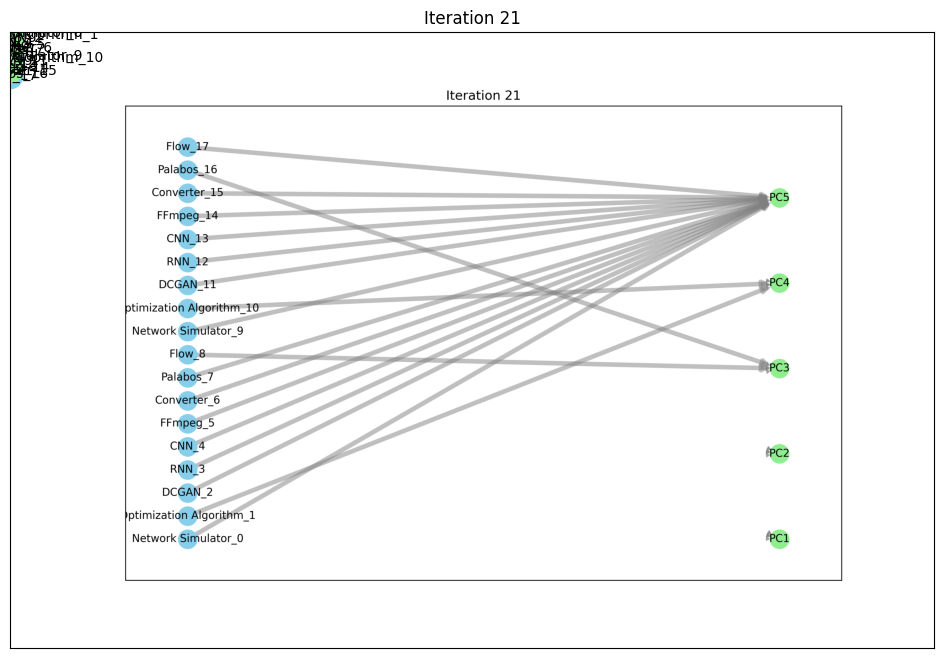

3805


In [156]:
optimal_path, total_duration = ACO(jobs, workers, matches, ants, alpha=3.875, beta=1, evap_coeff=0.5, Q=len(jobs), animate=1)

In [157]:
def display_duration_per_worker(optimal_path):
	worker_jobs = {}
	
	for job, worker in optimal_path: 
		if worker not in worker_jobs:
			worker_jobs[worker] = []
		worker_jobs[worker].append(job) 
	for worker, assigned_jobs in worker_jobs.items():
		worker_duration = calculate_worker_duration(assigned_jobs, worker)
		print(f"Worker: {worker.name}, Total Duration: {format_duration(worker_duration)}")

# Example usage after running ACO and getting optimal_path
display_duration_per_worker(optimal_path)

Worker: PC5, Total Duration: 1 hours 3 minutes 25 seconds
Worker: PC4, Total Duration: 0 hours 13 minutes 53 seconds
Worker: PC3, Total Duration: 0 hours 11 minutes 8 seconds


In [158]:
print("Optimal Path:")
for job, worker in optimal_path:
    print(f"Job: {job.name}, Worker: {worker.name}")
print(f"Total Processing Duration: {format_duration(total_duration)}")

Optimal Path:
Job: Network Simulator, Worker: PC5
Job: Optimization Algorithm, Worker: PC4
Job: DCGAN, Worker: PC5
Job: RNN, Worker: PC5
Job: CNN, Worker: PC5
Job: FFmpeg, Worker: PC5
Job: Converter, Worker: PC5
Job: Palabos, Worker: PC5
Job: Flow, Worker: PC3
Job: Network Simulator, Worker: PC5
Job: Optimization Algorithm, Worker: PC4
Job: DCGAN, Worker: PC5
Job: RNN, Worker: PC5
Job: CNN, Worker: PC5
Job: FFmpeg, Worker: PC5
Job: Converter, Worker: PC5
Job: Palabos, Worker: PC3
Job: Flow, Worker: PC5
Total Processing Duration: 1 hours 3 minutes 25 seconds


In [159]:
def find_optimal_path(jobs, workers, alpha=3.875, beta=1, evap_coeff=0.5, Q=len(jobs), iterations=50, verbose=0):
    """
    Executes the ACO function multiple times to find the best path with the lowest total duration.
    
    :param jobs: List of jobs.
    :param matches: List of Match objects.
    :param ants: List of Ant objects.
    :param alpha: Pheromone importance.
    :param beta: Heuristic importance.
    :param evap_coeff: Pheromone evaporation coefficient.
    :param Q: Constant for pheromone deposition.
    :param iterations: Number of times to run the ACO function.
    :return: A tuple containing the optimal path and the lowest total duration found.
    """
    best_path = None
    lowest_duration = float('inf')

    for i in range(iterations):
        matches = create_matches(jobs,workers,0.1)    
        ants = []
        for j in range(1, 4):
            ants.append(Ant(id=j))
        # Run the ACO algorithm
        optimal_path, total_duration = ACO(jobs, workers, matches, ants, alpha, beta, evap_coeff, Q)

        # Check if the current run's duration is the lowest
        if total_duration < lowest_duration:
            lowest_duration = total_duration
            best_path = optimal_path
        if verbose:
            print(f"Iteration {i+1}: Duration={total_duration}, Best Duration={lowest_duration}")
    return best_path, lowest_duration

# Usage:
if find_optimal:
    best_path, lowest_duration = find_optimal_path(jobs, workers, alpha=3.875, beta=1, evap_coeff=0.7, Q=len(jobs), iterations=50, verbose=1)
    
    print("Optimal Path:", [(job.name, worker.name) for job, worker in best_path])
    print("Lowest Total Duration:", lowest_duration)


In [160]:
if all_jobs:
    # Define dataset paths
    job_datasets = [f"data/jobs{i}.csv" for i in range(9, 91, 9)]
    
    results = []
    
    for job_path in job_datasets:
        # Load jobs data for each dataset
        job_data = pd.read_csv(job_path)
        jobs = create_jobs_from_df(job_data)
    
        # Run ACO
        optimal_path, total_duration = find_optimal_path(jobs, workers, alpha=3.875, beta=1, evap_coeff=0.7, Q=len(jobs), iterations=100)
    
        # Store the result with path and duration
        results.append({
        "job_dataset": job_path,
        "optimal_path": [(job.name, worker.name) for job, worker in optimal_path],
        "total_duration": total_duration
        })
    
    # Display results sorted by total duration
    for result in sorted(results, key=lambda x: x["total_duration"]):
        print(f"Dataset: {result['job_dataset']}")
        print(f"Optimal Path: {result['optimal_path']}")
        print(f"Total Duration: {format_duration(result['total_duration'])} hours, minutes, and seconds")  # format as needed
        print("\n")

In [162]:
from itertools import product
from tqdm import tqdm

def fine_tune_ACO(jobs, workers, initial_pheromones, num_ants_list, alpha_values, beta_values, evap_coeffs, Q_values, max_iterations=1000, tolerance=1e-5):
    """
    Fine-tunes the ACO algorithm by testing all combinations of the given parameter values.
    
    :param jobs: List of job objects.
    :param workers: List of worker objects.
    :param initial_pheromones: List of initial pheromone levels to test.
    :param num_ants_list: List of numbers of ants to test.
    :param alpha_values: List of alpha values to test.
    :param beta_values: List of beta values to test.
    :param evap_coeffs: List of evaporation coefficients to test.
    :param Q_values: List of Q values to test.
    :param max_iterations: Maximum number of iterations for each ACO run.
    :param tolerance: Convergence tolerance for each ACO run.
    :return: Sorted list of results with total duration and corresponding parameters.
    """
    # Initialize a list to store results
    results = []
   
    # Calculate the total number of combinations for tqdm
    total_combinations = len(initial_pheromones) * len(num_ants_list) * len(alpha_values) * len(beta_values) * len(evap_coeffs) * len(Q_values)

    # Generate all combinations of the parameter values
    for initial_pheromone, num_ants, alpha, beta, evap_coeff, Q in tqdm(product(initial_pheromones, num_ants_list, alpha_values, beta_values, evap_coeffs, Q_values), total=total_combinations, desc="Fine-tuning parameters"):
        
        # Create matches for the current initial pheromone level
        matches = create_matches(jobs, workers, initial_pheromone)
       
        # Create ants for the current number of ants
        ants = [Ant(id=i) for i in range(1, num_ants + 1)]
       
        # Run the ACO algorithm with the current combination of parameters
        optimal_path, total_duration = ACO(jobs, matches, ants, alpha, beta, evap_coeff, Q, max_iterations, tolerance, max_iterations/2)
       
        # Store the result with parameters for sorting later
        results.append({
            'total_duration': total_duration,
            'parameters': {
                'initial_pheromone': initial_pheromone,
                'num_ants': num_ants,
                'alpha': alpha,
                'beta': beta,
                'evap_coeff': evap_coeff,
                'Q': Q
            }
        })

    # Sort results by total duration in ascending order
    results.sort(key=lambda x: x['total_duration'])

    # Print sorted results
    for result in results:
        params = result['parameters']
        print(f"Total Duration: {result['total_duration']} | Parameters: Initial Pheromone: {params['initial_pheromone']}, "
              f"Num Ants: {params['num_ants']}, Alpha: {params['alpha']}, Beta: {params['beta']}, "
              f"Evap Coeff: {params['evap_coeff']}, Q: {params['Q']}")

    return results

# Define the parameters based on provided ranges and scaling method
def define_parameter_sets(jobs, workers):
    # Number of jobs (nodes) used to scale Q
    N = len(jobs)
    
    # Define parameter sets
    initial_pheromones = np.linspace(0.1, 1.0, 5).tolist()  # Initial pheromone level τ₀ from 0.1 to 1.0
    num_ants_list = [int(x) for x in np.linspace(N, 2 * N, 10).tolist()]  # Number of ants from N to 2N
    alpha_values = np.linspace(0.5, 5, 5).tolist()  # Alpha (α) values from 0.5 to 5
    beta_values = np.linspace(1, 10, 5).tolist()  # Beta (β) values from 1 to 10
    evap_coeffs = np.linspace(0.1, 0.9, 5).tolist()  # Evaporation coefficient (ρ) from 0.1 to 0.9

    # Q values scaled by path length (N) with k ranging from 1 to 5
    Q_values = [k * N for k in range(1, 6)]

    # Combine parameter sets for fine-tuning
    return initial_pheromones, num_ants_list, alpha_values, beta_values, evap_coeffs, Q_values

# Usage to retrieve parameter sets
initial_pheromones, num_ants_list, alpha_values, beta_values, evap_coeffs, Q_values = define_parameter_sets(jobs, workers)
print("Initial Pheromones:", initial_pheromones)
print("Number of Ants:", num_ants_list)
print("Alpha Values:", alpha_values)
print("Beta Values:", beta_values)
print("Evaporation Coefficients:", evap_coeffs)
print("Q Values:", Q_values)

if fine_tune:
    # Run the fine-tuning function
    fine_tune_ACO(jobs, workers, initial_pheromones, num_ants_list, alpha_values, beta_values, evap_coeffs, Q_values)

Initial Pheromones: [0.1, 0.325, 0.55, 0.775, 1.0]
Number of Ants: [18, 20, 22, 24, 26, 28, 30, 32, 34, 36]
Alpha Values: [0.5, 1.625, 2.75, 3.875, 5.0]
Beta Values: [1.0, 3.25, 5.5, 7.75, 10.0]
Evaporation Coefficients: [0.1, 0.30000000000000004, 0.5, 0.7000000000000001, 0.9]
Q Values: [18, 36, 54, 72, 90]
